In [70]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import time
import pickle as pk
from edo_fdm_model import fdm
import matplotlib.pyplot as plt

# Turn interactive plotting off
plt.ioff()

In [71]:
k = 1
t_lower = 0.0
t_upper = 10
phi = 0.2
ksi = 0.0
cb = 0.15
C_nmax = 0.55
mi_n = 0.2
lambd_bn = 0.1
y_n = 0.1

size_t = int(((t_upper - t_lower) / (k)))

lmb_var = 0.4

lmb_list = np.linspace(
    1.8 * (1 - lmb_var), 1.8 * (1 + lmb_var), num=size_t + 1, endpoint=True
)

print(
    "Steps in time = {:d}\n".format(
        size_t,
    )
)

t_np = np.linspace(t_lower, t_upper, num=size_t + 1, endpoint=True)

for i, lbm_nb in enumerate(lmb_list):
    if i == 0:
        Cp_old, Cl_old = fdm(
            k,
            phi,
            ksi,
            cb,
            C_nmax,
            lbm_nb,
            mi_n,
            lambd_bn,
            y_n,
            t_lower,
            t_upper,
            plot=False,
        )

    else:
        Cp_new, Cl_new = fdm(
            k,
            phi,
            ksi,
            cb,
            C_nmax,
            lbm_nb,
            mi_n,
            lambd_bn,
            y_n,
            t_lower,
            t_upper,
            plot=False,
        )

        Cp_old = np.vstack((Cp_old.copy(), Cp_new))
        Cl_old = np.vstack((Cl_old.copy(), Cl_new))

    print(i + 1, "de", len(lmb_list))

Steps in time = 10

1 de 11
2 de 11
3 de 11
4 de 11
5 de 11
6 de 11
7 de 11
8 de 11
9 de 11
10 de 11
11 de 11


In [72]:
tt, ll = np.meshgrid(t_np, lmb_list)

data_input_np = np.array([Cl_old.flatten(), Cp_old.flatten()]).T

if torch.cuda.is_available():
    device = torch.device("cuda")
    t = (
        torch.tensor(tt, dtype=torch.float32, requires_grad=True)
        .reshape(-1, 1)
        .to(device)
    )
    lambd_nb = (
        torch.tensor(ll, dtype=torch.float32, requires_grad=True)
        .reshape(-1, 1)
        .to(device)
    )
    data_input = torch.tensor(data_input_np, dtype=torch.float32).to(device)

else:
    device = torch.device("cpu")
    t = torch.tensor(tt, dtype=torch.float32, requires_grad=True).reshape(-1, 1)
    lambd_nb = torch.tensor(ll, dtype=torch.float32, requires_grad=True).reshape(-1, 1)
    data_input = torch.tensor(data_input_np, dtype=torch.float32)

print(device)

cuda


In [73]:
t.shape

torch.Size([121, 1])

In [74]:
activation_dict = {
    "Elu": nn.ELU,
    "LeakyReLU": nn.LeakyReLU,
    "Sigmoid": nn.Sigmoid,
    "Softplus": nn.Softplus,
    "Tanh": nn.Tanh,
    "Linear": nn.Linear,
    "ReLU": nn.ReLU,
    "RReLU": nn.RReLU,
    "SELU": nn.SELU,
    "CELU": nn.CELU,
    "GELU": nn.GELU,
    "SiLU": nn.SiLU,
    "GLU": nn.GLU,
}

In [75]:
arch_str = "Tanh--32__Tanh--32__Tanh--32__GELU--32"

In [76]:
def generate_model(arch_str):
    hidden_layers = arch_str.split("__")

    modules = []

    for params in hidden_layers:
        if len(params) != 0:
            activation, out_neurons = params.split("--")

            if len(modules) == 0:
                if activation == "Linear":
                    modules.append(activation_dict[activation](2, int(out_neurons)))

                else:
                    modules.append(nn.Linear(2, int(out_neurons)))
                    modules.append(activation_dict[activation]())

            else:
                if activation == "Linear":
                    modules.append(
                        activation_dict[activation](int(in_neurons), int(out_neurons))
                    )

                else:
                    modules.append(nn.Linear(int(in_neurons), int(out_neurons)))
                    modules.append(activation_dict[activation]())

            in_neurons = out_neurons

    modules.append(nn.Linear(int(in_neurons), 2))

    return nn.Sequential(*modules)

In [77]:
model = generate_model(arch_str).to(device)

print(model)

Sequential(
  (0): Linear(in_features=2, out_features=32, bias=True)
  (1): Tanh()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): Tanh()
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): Tanh()
  (6): Linear(in_features=32, out_features=32, bias=True)
  (7): GELU(approximate='none')
  (8): Linear(in_features=32, out_features=2, bias=True)
)


In [78]:
def initial_condition(t):
    Cl = torch.zeros_like(t)
    Cp = torch.zeros_like(t) + 0.2
    return torch.cat([Cl, Cp], dim=1)

In [79]:
def pde(t, lambd_nb, model):
    mesh = torch.cat([t, lambd_nb], dim=1)

    Cl, Cp = model(mesh).split(1, dim=1)

    # Calculando Cp

    dCp_dt = torch.autograd.grad(
        Cp,
        t,
        grad_outputs=torch.ones_like(Cp),
        create_graph=True,
        retain_graph=True,
    )[0]

    Cp_eq = (cb - lambd_nb * Cl) * Cp * phi - dCp_dt

    # Calculando Cl

    dCl_dt = torch.autograd.grad(
        Cl,
        t,
        grad_outputs=torch.ones_like(Cl),
        create_graph=True,
        retain_graph=True,
    )[0]

    Cl_eq = (y_n * Cp * (C_nmax - 1) - (lambd_bn * Cp + mi_n)) * Cl * phi - dCl_dt

    del dCl_dt
    del dCp_dt

    torch.cuda.empty_cache()

    return torch.cat([Cl_eq, Cp_eq], dim=1)

In [80]:
def train(n_epochs, batch_size, decay_rate, model,lambd_nb,device,data_input,t):
    loss_fn = nn.MSELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    lr_scheduler = optim.lr_scheduler.ExponentialLR(
        optimizer=optimizer, gamma=decay_rate
    )
    loss_fn = nn.MSELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    decay_rate = 0.99

    lr_scheduler = optim.lr_scheduler.ExponentialLR(
        optimizer=optimizer, gamma=decay_rate
    )
    C_pde_loss_it = torch.zeros(n_epochs).to(device)
    C_data_loss_it = torch.zeros(n_epochs).to(device)
    C_initial_loss_it = torch.zeros(n_epochs).to(device)
    C_initial = initial_condition(t).to(device)

    for epoch in range(n_epochs):
        for i in range(0, len(t), batch_size):
            t_initial = torch.zeros_like(t[i : i + batch_size])

            mesh = torch.cat([t_initial, lambd_nb[i : i + batch_size]], dim=1)
            C_initial_pred = model(mesh)

            loss_initial = loss_fn(C_initial[i : i + batch_size], C_initial_pred)

            mesh = torch.cat(
                [t[i : i + batch_size], lambd_nb[i : i + batch_size]], dim=1
            )
            C_pred = model(mesh)

            loss_pde = loss_fn(
                pde(t[i : i + batch_size], lambd_nb[i : i + batch_size], model),
                torch.cat([t_initial, t_initial], dim=1),
            )

            loss_data = loss_fn(C_pred, data_input[i : i + batch_size])

            loss = 10 * loss_initial + loss_pde + 10 * loss_data

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # lr_scheduler.step()

        C_pde_loss_it[epoch] = loss_pde.item()
        C_initial_loss_it[epoch] = loss_initial.item()
        C_data_loss_it[epoch] = loss_data.item()

        if epoch % 100 == 0:
            print(f"Finished epoch {epoch}, latest loss {loss}")

    return model, C_pde_loss_it, C_initial_loss_it, C_data_loss_it


decay_rate = 0.99
n_epochs = 500
batch_size = 100000

model, C_pde_loss_it, C_initial_loss_it, C_data_loss_it = train(
    n_epochs=n_epochs,
    batch_size=batch_size,
    decay_rate=decay_rate,
    model=model,
    lambd_nb=lambd_nb,
    device = device,
    data_input=data_input,
    t=t
)

Finished epoch 0, latest loss 3.18923282623291


Finished epoch 100, latest loss 0.14012283086776733
Finished epoch 200, latest loss 0.04114152863621712
Finished epoch 300, latest loss 0.012034283019602299
Finished epoch 400, latest loss 0.00854608416557312


In [81]:
pinn_file = "epochs_{}__batch_{}__arch_".format(n_epochs, batch_size) + arch_str

<Figure size 1600x2700 with 0 Axes>

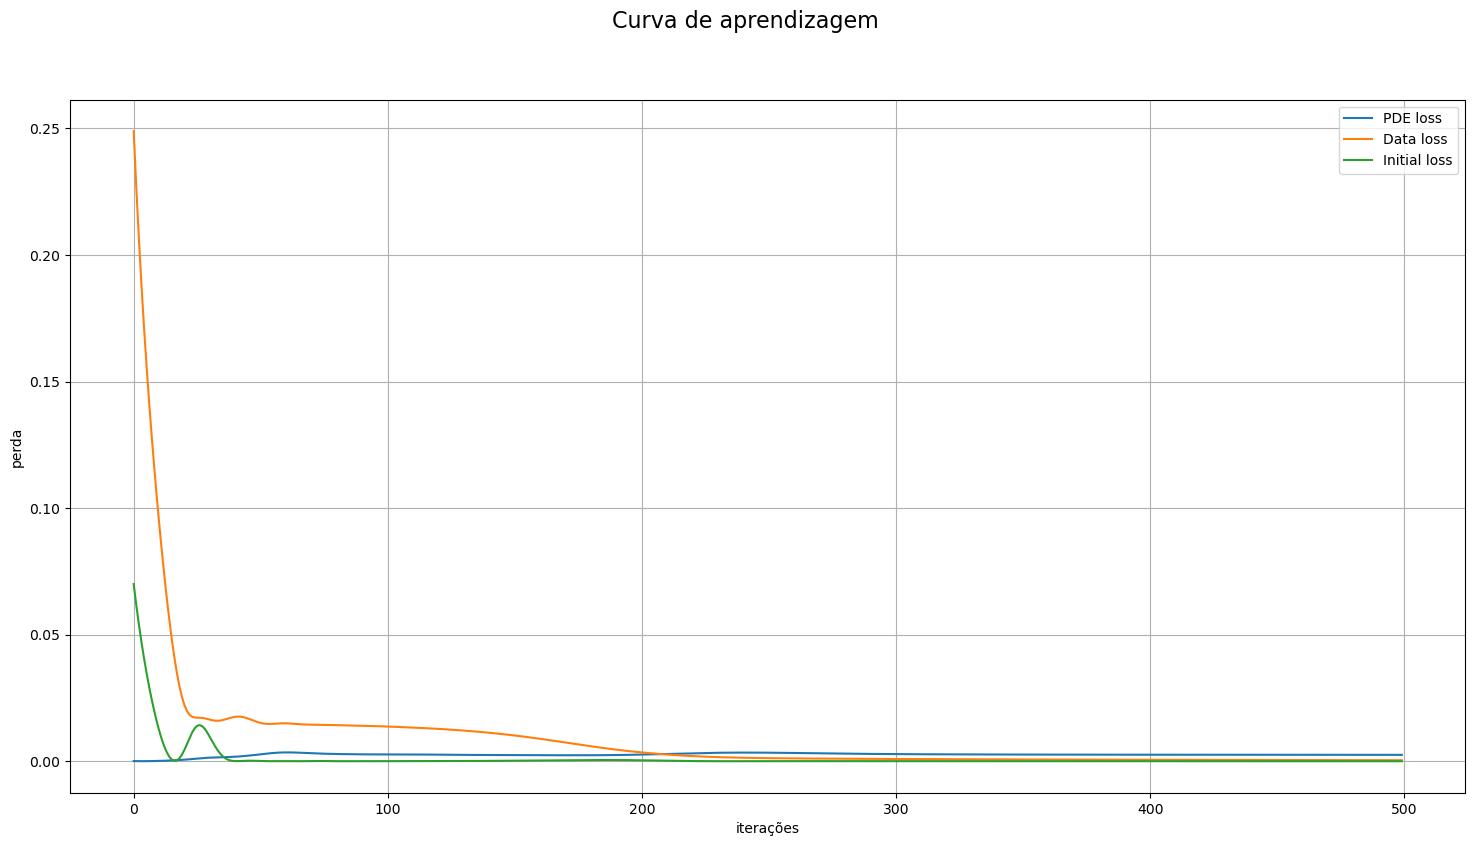

In [82]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[18, 9])

fig.suptitle("Curva de aprendizagem", fontsize=16)

# Plotango 3D
ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel("iterações")
ax.set_ylabel("perda")
ax.plot(
    range(len(C_pde_loss_it.cpu().numpy())),
    C_pde_loss_it.cpu().numpy(),
    label="PDE loss",
)
ax.plot(
    range(len(C_data_loss_it.cpu().numpy())),
    C_data_loss_it.cpu().numpy(),
    label="Data loss",
)
ax.plot(
    range(len(C_initial_loss_it.cpu().numpy())),
    C_initial_loss_it.cpu().numpy(),
    label="Initial loss",
)
# ax.set_yscale("log")
ax.grid()
ax.legend()

plt.show()

In [83]:
model_cpu = model.to("cpu")

speed_up = []

mesh = torch.cat([t, lambd_nb], dim=1).to("cpu")

for i in range(10):
    fdm_start = time.time()

    for lbm_nb in lmb_list:
        struct_name = (
            "k--"
            + str(k)
            + "__phi--0.2__ksi--0.0__cb--0.15__Cn_max--0.55__lambd_nb--"
            + str(lbm_nb)
            + "__mi_n--0.2__lambd_bn--0.1__y_n--0.1__t_lower--"
            + str(t_lower)
            + "__t_upper--"
            + str(t_upper)
        )

        _, _ = fdm(
            k,
            phi,
            ksi,
            cb,
            C_nmax,
            lbm_nb,
            mi_n,
            lambd_bn,
            y_n,
            t_lower,
            t_upper,
        )

    fdm_end = time.time()

    pinn_start = time.time()

    with torch.no_grad():
        Cl_pinn, Cp_pinn = model_cpu(mesh).split(1, dim=1)

    pinn_end = time.time()

    fdm_time = fdm_end - fdm_start

    pinn_time = pinn_end - pinn_start

    speed_up.append(fdm_time / pinn_time)

In [84]:
mean_speed_up = np.mean(speed_up)
std_speed_up = np.std(speed_up)

rmse = np.mean(
    [
        ((Cl_p[0] - Cl_f) ** 2 + (Cp_p[0] - Cp_f) ** 2) ** 0.5
        for Cl_p, Cp_p, Cl_f, Cp_f in zip(
            Cl_pinn, Cp_pinn, Cl_old.flatten(), Cp_old.flatten()
        )
    ]
)

max_ae = np.max(
    [
        [((Cl_p[0] - Cl_f) ** 2) ** 0.5, ((Cp_p[0] - Cp_f) ** 2) ** 0.5]
        for Cl_p, Cp_p, Cl_f, Cp_f in zip(
            Cl_pinn, Cp_pinn, Cl_old.flatten(), Cp_old.flatten()
        )
    ]
)

In [85]:
output = {
    "rmse": rmse,
    "max_ae": max_ae,
    "mean_speed_up": mean_speed_up,
    "std_speed_up": std_speed_up,
    "Cl_pinn": Cl_pinn,
    "Cp_pinn": Cp_pinn,
}

In [86]:
print("Erro absoluto médio", rmse)
print("Erro absoluto máximo", max_ae)
print("Speed Up: {} +/-{}".format(mean_speed_up, std_speed_up))

Erro absoluto médio 0.023326155
Erro absoluto máximo 0.072117984
Speed Up: 0.2724138246449487 +/-0.2203980984134883


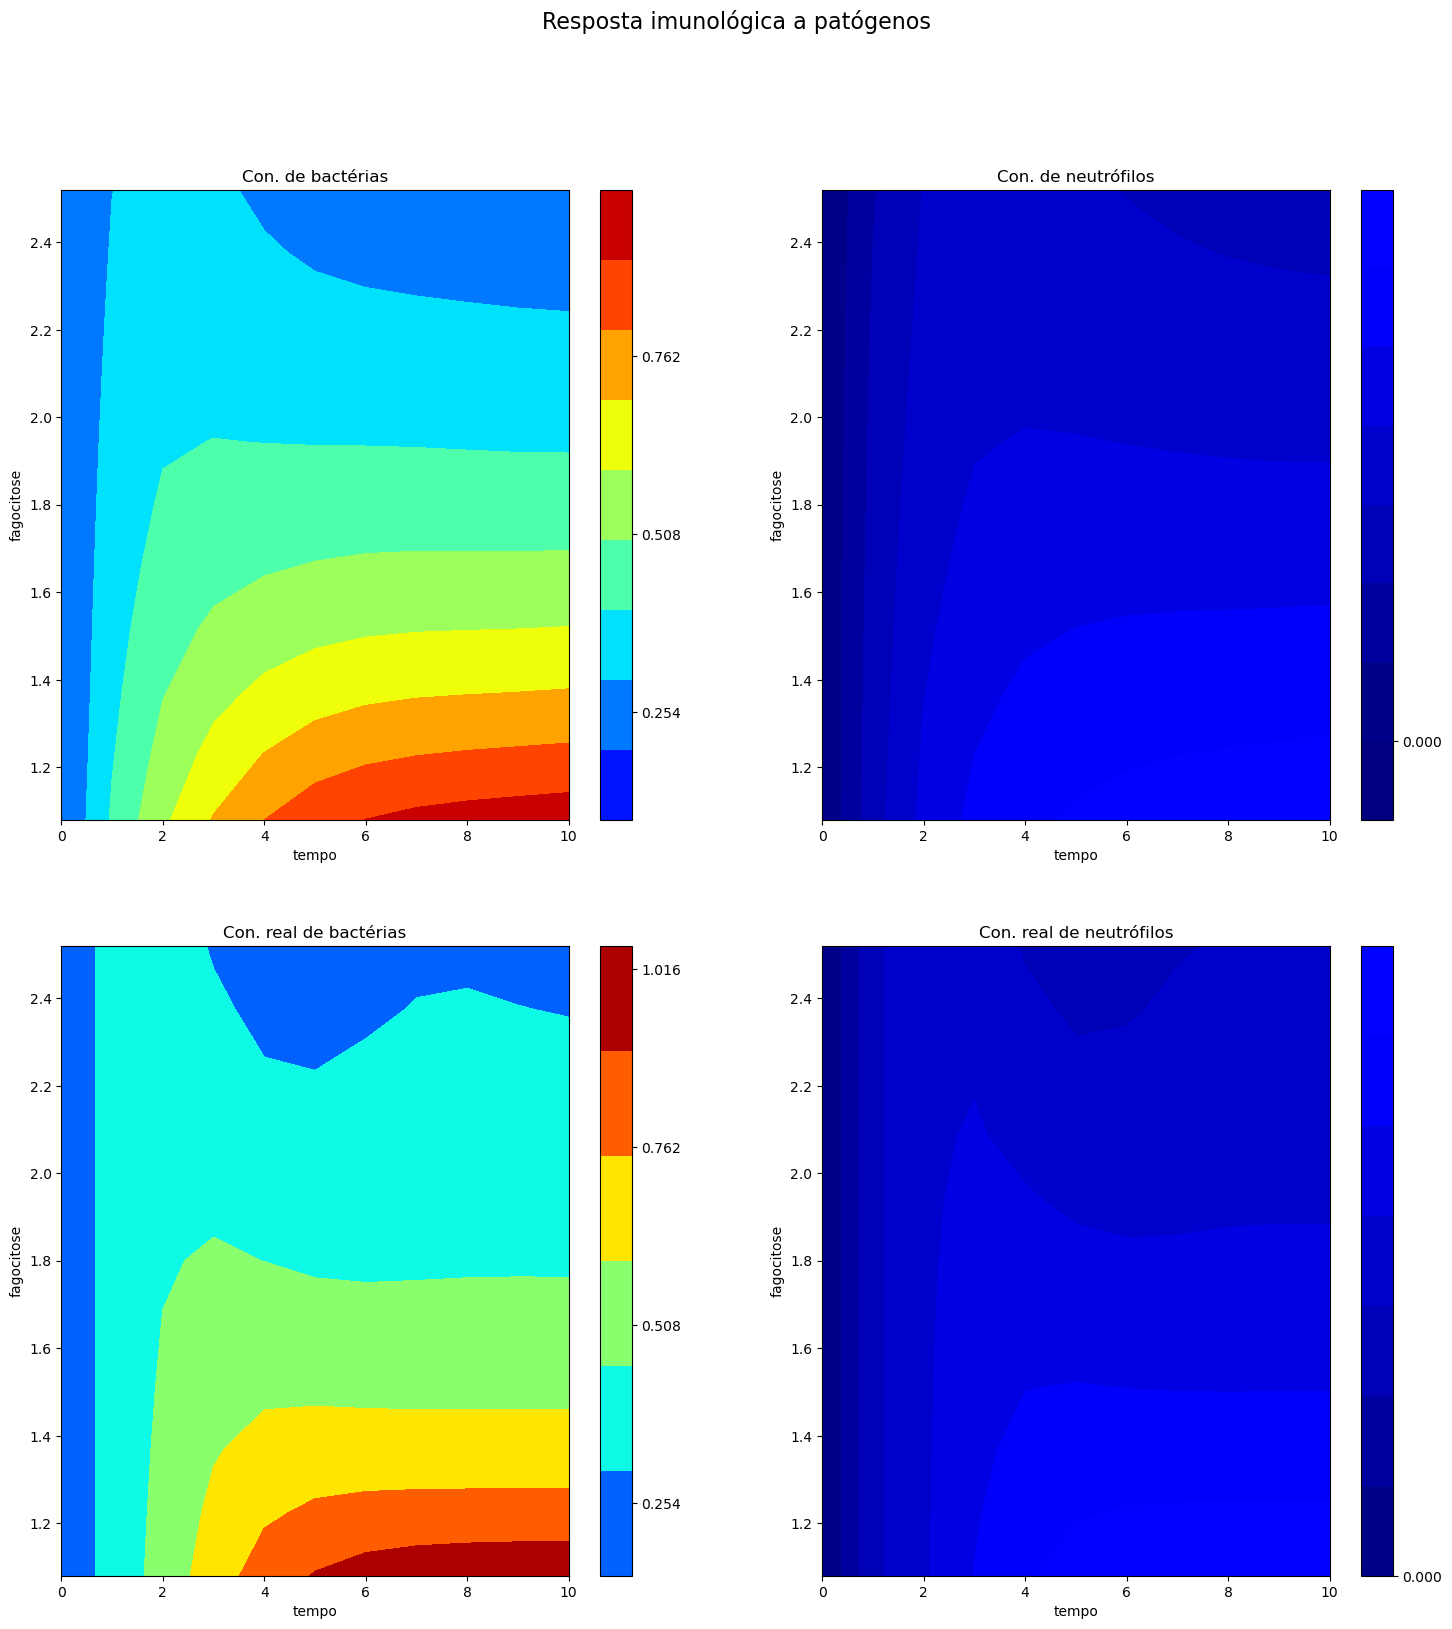

In [87]:
Cl_pinn_np = Cl_pinn.detach().numpy().reshape(size_t + 1, size_t + 1)
Cp_pinn_np = Cp_pinn.detach().numpy().reshape(size_t + 1, size_t + 1)

fig = plt.figure(figsize=[18, 18])

fig.suptitle("Resposta imunológica a patógenos", fontsize=16)

vmin = 0
vmax = np.max(
    [
        np.max(Cp_pinn.cpu().numpy()),
        np.max(Cl_pinn.cpu().numpy()),
        np.max(Cp_old),
        np.max(Cl_old),
    ]
)

# Plotango 3D
ax = fig.add_subplot(2, 2, 1)

contour = ax.contourf(
    tt,
    ll,
    Cp_pinn_np,
    cmap="jet",
    vmin=vmin,
    vmax=vmax,
)
ax.set_title("Con. de bactérias")
ax.set_xlabel("tempo")
ax.set_ylabel("fagocitose")
colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

# Plotando 2D

ax = fig.add_subplot(2, 2, 2)

contour = ax.contourf(
    tt,
    ll,
    Cl_pinn_np,
    cmap="jet",
    vmin=vmin,
    vmax=vmax,
)
ax.set_title("Con. de neutrófilos")
ax.set_xlabel("tempo")
ax.set_ylabel("fagocitose")

colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

# Plotango 3D
ax = fig.add_subplot(2, 2, 3)

contour = ax.contourf(
    tt,
    ll,
    Cp_old.reshape(size_t + 1, size_t + 1),
    cmap="jet",
    vmin=vmin,
    vmax=vmax,
)
ax.set_title("Con. real de bactérias")
ax.set_xlabel("tempo")
ax.set_ylabel("fagocitose")
colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

# Plotando 2D

ax = fig.add_subplot(2, 2, 4)

contour = ax.contourf(
    tt,
    ll,
    Cl_old.reshape(size_t + 1, size_t + 1),
    cmap="jet",
    vmin=vmin,
    vmax=vmax,
)
ax.set_title("Con. real de neutrófilos")
ax.set_xlabel("tempo")
ax.set_ylabel("fagocitose")

colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

plt.show()

In [88]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[16, 27])

fig.suptitle("Concentração de patógenos e leucócitos", fontsize=16)


vmin = 0

cp_real_1 = Cp_old[0, :]
cl_real_1 = Cl_old[0, :]
cp_pinn_1 = Cp_pinn_np[0, :]
cl_pinn_1 = Cl_pinn_np[0, :]
fag_1 = lambd_nb[0 * (size_t + 1)].cpu().detach().numpy()[0]

cp_real_2 = Cp_old[500, :]
cl_real_2 = Cl_old[500, :]
cp_pinn_2 = Cp_pinn_np[500, :]
cl_pinn_2 = Cl_pinn_np[500, :]
fag_2 = lambd_nb[500 * (size_t + 1)].cpu().detach().numpy()[0]

cp_real_3 = Cp_old[1000, :]
cl_real_3 = Cl_old[1000, :]
cp_pinn_3 = Cp_pinn_np[1000, :]
cl_pinn_3 = Cl_pinn_np[1000, :]
fag_3 = lambd_nb[1000 * (size_t + 1)].cpu().detach().numpy()[0]

# Plotango 3D
ax = fig.add_subplot(3, 1, 1)

ax.plot(t_np, cp_real_1, label="Pat fdm = {:.2f}".format(fag_1))
ax.plot(t_np, cl_real_1, label="Leu. fdm = {:.2f}".format(fag_1))
ax.plot(t_np, cp_pinn_1, "--", label="Pat. pinn fag. = {:.2f}".format(fag_1))
ax.plot(t_np, cl_pinn_1, "-.", label="Leu. pinn fag. = {:.2f}".format(fag_1))
ax.set_xlabel("X")
ax.set_ylabel("Y")

vmax = np.max(
    [
        np.max(cp_real_1),
        np.max(cl_real_1),
        np.max(cp_pinn_1),
        np.max(cl_pinn_1),
    ]
)
ax.set_ylim(vmin, vmax + 0.1)
ax.legend()
ax.grid()

ax = fig.add_subplot(3, 1, 2)

ax.plot(t_np, cp_real_2, label="Pat fdm = {:.2f}".format(fag_1))
ax.plot(t_np, cl_real_2, label="Leu. fdm = {:.2f}".format(fag_1))
ax.plot(t_np, cp_pinn_2, "--", label="Pat. pinn fag. = {:.2f}".format(fag_2))
ax.plot(t_np, cl_pinn_2, "-.", label="Leu. pinn fag. = {:.2f}".format(fag_2))
ax.set_xlabel("X")
ax.set_ylabel("Y")
vmax = np.max(
    [
        np.max(cp_real_2),
        np.max(cl_real_2),
        np.max(cp_pinn_2),
        np.max(cl_pinn_2),
    ]
)
ax.set_ylim(vmin, vmax + 0.1)
ax.legend()
ax.grid()

ax = fig.add_subplot(3, 1, 3)

ax.plot(t_np, cp_real_3, label="Pat fdm = {:.2f}".format(fag_1))
ax.plot(t_np, cl_real_3, label="Leu. fdm = {:.2f}".format(fag_1))
ax.plot(t_np, cp_pinn_3, "--", label="Pat. pinn fag. = {:.2f}".format(fag_3))
ax.plot(t_np, cl_pinn_3, "-.", label="Leu. pinn fag. = {:.2f}".format(fag_3))
ax.set_xlabel("X")
ax.set_ylabel("Y")
vmax = np.max(
    [
        np.max(cp_real_3),
        np.max(cl_real_3),
        np.max(cp_pinn_3),
        np.max(cl_pinn_3),
    ]
)
ax.set_ylim(vmin, vmax + 0.1)
ax.legend()
ax.grid()

plt.show()

IndexError: index 500 is out of bounds for axis 0 with size 11

In [ ]:
import glob

glob.glob("edo_pinn_sim/*")

['edo_pinn_sim/struct.txt']